<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

<h2 style="text-align: center;"><b>Основы фреймворка TensorFlow</b></h2>

<img src="https://cdn-images-1.medium.com/max/1600/1*eFRgat2Iy6wZpi_DEItKgA.png" width=300 height=225>

<h4 style="text-align: center;"><b>Составитель: Илья Захаркин (ФИВТ МФТИ, NeurusLab). По всем вопросам в Telegram: <a>@ilyazakharkin</a></b></h4>

В этом ноутбуке мы более близко познакомимся с TF и попрактикуемся в классификации на FashionMNIST с помощью этого фреймворка. Пайплайн у него очень похож на PyTorch и Keras, однако есть много технических нюансов, которым и посвящён этот ноутбук.

*Примечание*: рекомендуется выполнять этот ноутбук в Google Colab во избежание проблем с установкой (если ставить `tensorflow`  без GPU, то проблем, на самом деле, быть не должно).

<h3 style="text-align: center;"><b>Основы: граф и сессия</b></h3>

Если tf не установлен:

In [0]:
# !pip install tensorflow

Импортируем:

In [0]:
import tensorflow as tf

In [0]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11471679565401023182, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8070511074939932969
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1054626550067828852
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14800692839
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17606376770771680972
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

В TF есть две основные сущности -- это ***граф вычислений `tf.Graph()`*** и ***сессия `tf.Session()`***.

Сначала *строится* граф вычислений, а потом в сессии он *исполняется*.

Пример графа вычислений (очень условный):

<img src="https://camo.qiitausercontent.com/137bc298bf30fe06e61b59a638fea966d272f2b8/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f313034362f38663430386438392d666563362d643761632d633961662d3865393061383039613233622e706e67" width=300 height=400>

А вот пример реального графа (скрин из TensorBoard):

<img src="https://blog.altoros.com/wp-content/uploads/2016/05/visualizing-graphs-with-tensorboard-wxb-group.png">

То есть граф -- это нечто построенное нами до сессии, а сессия -- это то, во время чего все операции в графе исполняются (при подаче в него входных данных).

Помимо этого введения, есть много замечательных курсов по этому фреймворку, например:

* Начать можно с официального intro: https://www.tensorflow.org/guide/low_level_intro 
* Продолжить этими замечательными практикумами: https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd
* Посмотреть что-то здесь, если не очень понятно: https://github.com/Hvass-Labs/TensorFlow-Tutorials
* Закончить продвинутым курсом: https://github.com/sjchoi86/advanced-tensorflow

И не забудьте заглянуть в официальные туториалы: https://www.tensorflow.org/tutorials/

<h3 style="text-align: center;"><b>Основные объекты</b></h3>

Используя https://www.tensorflow.org/guide/low_level_intro

#### Тензоры (Tensor)

Центральный объект -- это **тензоры `tf.Tensor`**. Это те же `np.array` из `numpy`, только обёрнуты в специальный класс `tf.Tensor`.

Давайте сразу посмотрим на простой пример объявления двух констнатныз тензоров и взятия от них матричного произведения:

In [0]:
c = tf.constant([[1.0, 2.0], [3.0, 4.0]])
d = tf.constant([[1.0, 1.0], [0.0, 1.0]])
e = tf.matmul(c, d)

Посомтрим на типы того, чтоы мы создали:

In [0]:
c

<tf.Tensor 'Const:0' shape=(2, 2) dtype=float32>

In [0]:
d

<tf.Tensor 'Const_1:0' shape=(2, 2) dtype=float32>

In [0]:
e

<tf.Tensor 'MatMul:0' shape=(2, 2) dtype=float32>

Обратите внимание: выводится тип объекта, его имя, shape и тип элементов, которые лежат внутри тензора.

Как видим, никакой матрицы-результата мы не получили. Это потому, что мы лишь объявлии граф вычислений, но сами вычисления ещё не зпустили. Для этого нужно объявить сессию и исполнить в ней этот граф:

In [0]:
sess = tf.Session()

result = sess.run(e)

In [0]:
result

array([[1., 3.],
       [3., 7.]], dtype=float32)

In [0]:
type(result)

numpy.ndarray

Видим, что при выполнении графа произведение посчиталось и результат положился в виде `np.array` в переменную `result`.

Заметьте: мы не объявляли в начале отедльный граф, поэтмоу текущий граф вычислений можно оплучить так: `tf.get_default_graph()`

In [0]:
tf.get_default_graph()

Давайте визуализируем этот граф с помощью TensorBoard **(сработает только на локальной машине, не на Colab)**:

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-05-30 13:58:04--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 35.173.6.94, 52.45.111.123, 34.199.255.1, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.173.6.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16648024 (16M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  15.88M  39.8MB/s    in 0.4s    

2019-05-30 13:58:05 (39.8 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [16648024/16648024]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://1691b3a7.ngrok.io


In [0]:
writer = tf.summary.FileWriter('.')
writer.add_graph(tf.get_default_graph())
writer.flush()

In [0]:
# pip install tensorboard
# tensorboard --logdir .

Чтобы посмотреть на результат TensorBoard, перейдите в любом браузере по адресу `http://localhost:6006/#graphs` (работает только на локальной машине, не на Colab (однако есть способ, попробуйте разобраться самостоятельно: https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/)

<img src="https://www.tensorflow.org/images/getting_started_add.png">

Ещё пример:

In [0]:
a = tf.constant(3.0, dtype=tf.float32)
b = tf.constant(4.0)
total = a + b
print(a)
print(b)
print(total)

Tensor("Const_2:0", shape=(), dtype=float32)
Tensor("Const_3:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)


In [0]:
sess = tf.Session()
print(sess.run(total))

7.0


Поучительный прмиер, говорящий о том, что при генерации случайных чисел и запуске вычисления графа, вычисления одного тензора происходят **один раз на запуск**, то есть:

In [0]:
vec = tf.random_uniform(shape=(3,))
out1 = vec + 1
out2 = vec + 2
print(sess.run(vec))
print(sess.run(vec))
print(sess.run((out1, out2)))

[0.00206244 0.05620003 0.9380251 ]
[0.43834257 0.03517807 0.9747213 ]
(array([1.9931304, 1.3708564, 1.3472309], dtype=float32), array([2.9931304, 2.3708563, 2.347231 ], dtype=float32))


Обратите внимание, что у out1 и out2 был один и тот же тензор vec на входе.

#### Плейсхолдеры (Placeholder)

Для того чтобы иметь возможность подавать на вход графу какие-то свои тензоры, используют **`tf.Placeholder()`**.

In [0]:
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)
z = x + y

In [0]:
x

<tf.Tensor 'Placeholder:0' shape=<unknown> dtype=float32>

In [0]:
y

<tf.Tensor 'Placeholder_1:0' shape=<unknown> dtype=float32>

In [0]:
z

<tf.Tensor 'add_3:0' shape=<unknown> dtype=float32>

Это всё те же тензоры в графе вычислений, но они не имеют значений -- их нужно **"скормить" ("feed")** самому:

In [0]:
print(sess.run(z, feed_dict={x: 3, y: 4.5}))

7.5


== *"вычисли значения тензора z, если на вход подаются x=3 и y=4.5"*

In [0]:
print(sess.run(z, feed_dict={x: [1, 3], y: [2, 4]}))

[3. 7.]


== *"вычисли значения тензора z, если на вход подаются x=[1, 3] и y=[2, 4]"* 

#### Переменные (Variable)

Тензоры существуют только во время выполнения сессии, чтобы получить результат вычислений. Для того, чтобы сохранять значения тензоров, в TF есть **`tf.Variable()`**.

`tf.Variable` хранит в себе `tf.Tensor`, однако можно читать и менять его значения в течение нескольких сессий, то есть `Variable` ближе к питоновскому понятию переменной, которая хранится в оперативной памяти компьютера.

Создать переменную можно так:

In [0]:
my_variable = tf.get_variable("my_variable", [1, 2, 3])
my_variable

Instructions for updating:
Colocations handled automatically by placer.


<tf.Variable 'my_variable:0' shape=(1, 2, 3) dtype=float32_ref>

In [0]:
my_variable.graph

Сейчас она тоже прикреплена к графу по-умолчанию:

In [0]:
tf.get_default_graph()

(такой вывод можно сделать, потому что адреса графа в памяти совпадают)

Создадим ещё одну и инициализируем константной:

In [0]:
other_variable = tf.get_variable("other_variable", dtype=tf.int32,
                                 initializer=tf.constant([23, 42]))

Запустим сессию, чтобы посомтреть на значения переменных (сейчас должна быть ошибка):

In [0]:
sess.run(my_variable)
sess.run(other_variable)

FailedPreconditionError: ignored

Ничего не вышло, потому что сначала переменные надо инициализировать:

In [0]:
sess.run(tf.global_variables_initializer())

Теперь должно получиться:

In [0]:
sess.run(my_variable)

array([[[-0.3476057 ,  0.6820922 ,  0.82925665],
        [-0.10143781, -0.730499  , -0.75090116]]], dtype=float32)

In [0]:
sess.run(other_variable)

array([23, 42], dtype=int32)

Всё верно: вторая переменная ининцилизировалась своим значеним, заданным в конструкторе, а первая -- случайным "мусором".

<h3 style="text-align: center;"><b>К практике</b></h3>

Напишем свой нейрон на tensorflow. 

Ниже пример регрессии по 4 точкам с помощью одного нейрона 

In [0]:
x = tf.constant([[1], [2], [3], [4]], dtype=tf.float32)
y_true = tf.constant([[0], [-1], [-2], [-3]], dtype=tf.float32)

Нарисуем:

In [0]:
import matplotlib.pyplot as plt

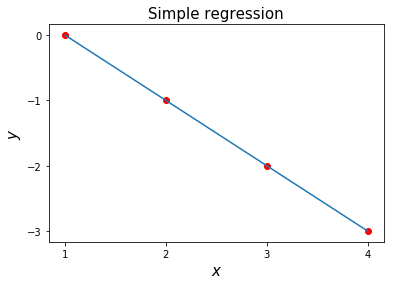

In [0]:
x_values, y_values = sess.run([x, y_true])

plt.scatter(x_values, y_values, c='r');
plt.plot(x_values, y_values);

plt.xticks(x_values)
plt.yticks(y_values)

plt.title('Simple regression', fontsize=15)
plt.xlabel('$x$', fontsize=15)
plt.ylabel('$y$', fontsize=15);

Объявим линейную регрессию:

In [0]:
linear_model = tf.layers.Dense(units=1)

y_pred = linear_model(x)

In [0]:
linear_model

In [0]:
y_pred

<tf.Tensor 'dense/BiasAdd:0' shape=(4, 1) dtype=float32>

Функция потерь -- среднеквадратичная, оптимизатор -- градиентный спуск:

In [0]:
loss = tf.losses.mean_squared_error(labels=y_true, predictions=y_pred)

optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

Instructions for updating:
Use tf.cast instead.


Иницилизируем переменные, обЪявим сессию и запусим в ней обучение:

In [0]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
for i in range(100):
    _, loss_value = sess.run((train, loss))
    print('loss: ', loss_value)

print(sess.run(y_pred))

loss:  0.95603096
loss:  0.7038852
loss:  0.52868444
loss:  0.4068756
loss:  0.32211566
loss:  0.26306462
loss:  0.22185387
loss:  0.19302356
loss:  0.17278513
loss:  0.1585098
loss:  0.1483736
loss:  0.14111076
loss:  0.1358431
loss:  0.13196121
loss:  0.12904222
loss:  0.12679276
loss:  0.12500916
loss:  0.12355015
loss:  0.122317694
loss:  0.12124379
loss:  0.12028116
loss:  0.11939705
loss:  0.11856875
loss:  0.11778041
loss:  0.11702113
loss:  0.11628321
loss:  0.115561455
loss:  0.114852116
loss:  0.114152655
loss:  0.113461316
loss:  0.112776786
loss:  0.11209825
loss:  0.11142506
loss:  0.11075681
loss:  0.11009319
loss:  0.10943397
loss:  0.10877899
loss:  0.10812814
loss:  0.10748132
loss:  0.10683848
loss:  0.10619958
loss:  0.10556448
loss:  0.10493326
loss:  0.10430583
loss:  0.10368217
loss:  0.10306225
loss:  0.102446035
loss:  0.10183351
loss:  0.101224646
loss:  0.100619465
loss:  0.10001788
loss:  0.09941987
loss:  0.09882546
loss:  0.09823457
loss:  0.09764727
loss: 

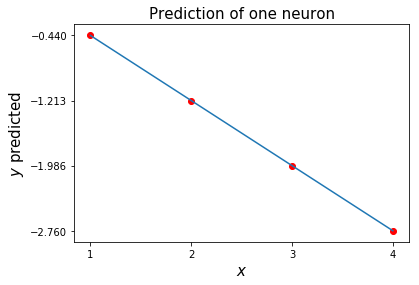

In [0]:
x_values, y_values = sess.run([x, y_pred])

plt.scatter(x_values, y_values, c='r');
plt.plot(x_values, y_values);

plt.xticks(x_values)
plt.yticks(y_values)

plt.title('Prediction of one neuron', fontsize=15)
plt.xlabel('$x$', fontsize=15)
plt.ylabel('$y$ predicted', fontsize=15);

<h3 style="text-align: center;"><b>FashionMNIST (5 баллов)</b></h3>

Для обучения нейросетей на TensorFlow обычно используют либо модуль `.keras` (который, по сути, является Keras'ом, только обращение к нему происходит через TF), либо модуль `tf.Slim`. В этом задании Вам нужно самостоятельно написть обучение нейросети на датасете FashionMNIST и добиться качества (поклассового `accuracy`) **больше, чем 0.9**.

Бейзланом к этому заданию является официальный туториал TensorFlow: https://www.tensorflow.org/tutorials/keras/basic_classification

*Hint*: можно использовать свёрточные слои и слои не из туториала

In [0]:
# Baseline tutorial-а

In [1]:
from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.13.1


In [0]:
fashion_mnist = keras.datasets.fashion_mnist

In [0]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [0]:
train_images.shape

(60000, 28, 28)

In [0]:
test_images.shape

(10000, 28, 28)

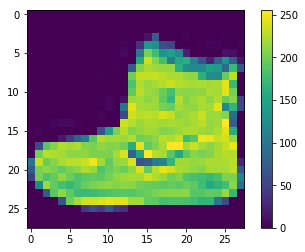

In [0]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()


In [0]:
train_images = train_images / 255.0

test_images = test_images / 255.0

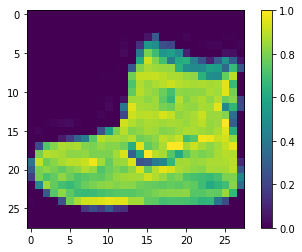

In [0]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()


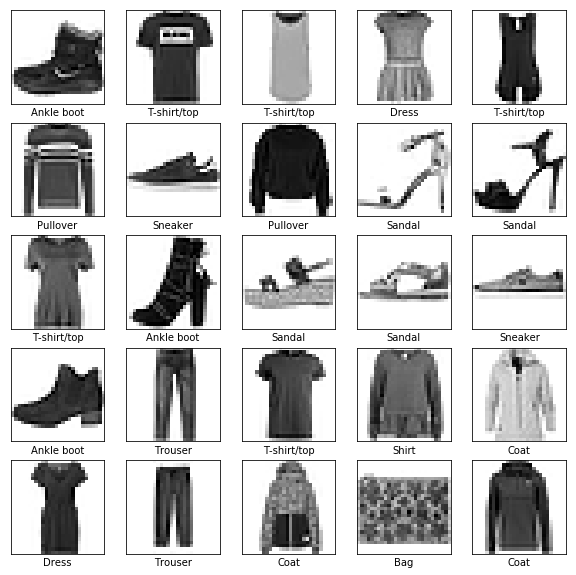

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])


In [0]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 5s 90us/sample - loss: 0.4956 - acc: 0.8259
Epoch 2/5
60000/60000 [==============================] - 5s 86us/sample - loss: 0.3743 - acc: 0.8636
Epoch 3/5
60000/60000 [==============================] - 5s 86us/sample - loss: 0.3337 - acc: 0.8787
Epoch 4/5
60000/60000 [==============================] - 5s 86us/sample - loss: 0.3121 - acc: 0.8857
Epoch 5/5
60000/60000 [==============================] - 5s 90us/sample - loss: 0.2916 - acc: 0.8925


In [0]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 1s 52us/sample - loss: 0.3414 - acc: 0.8774
Test accuracy: 0.8774


In [0]:
predictions = model.predict(test_images)

In [0]:
predictions[0]

array([1.2441207e-05, 5.7234905e-07, 3.1707639e-06, 2.3744099e-06,
       4.4779568e-05, 4.7694482e-03, 3.0884410e-06, 1.8524919e-02,
       1.2257142e-04, 9.7651666e-01], dtype=float32)

In [0]:
np.argmax(predictions[0])

9

In [0]:
test_labels[0]

9

In [0]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


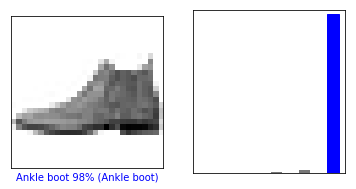

In [0]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

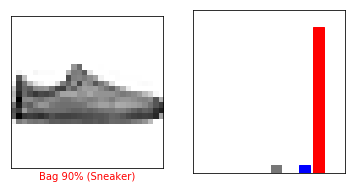

In [0]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

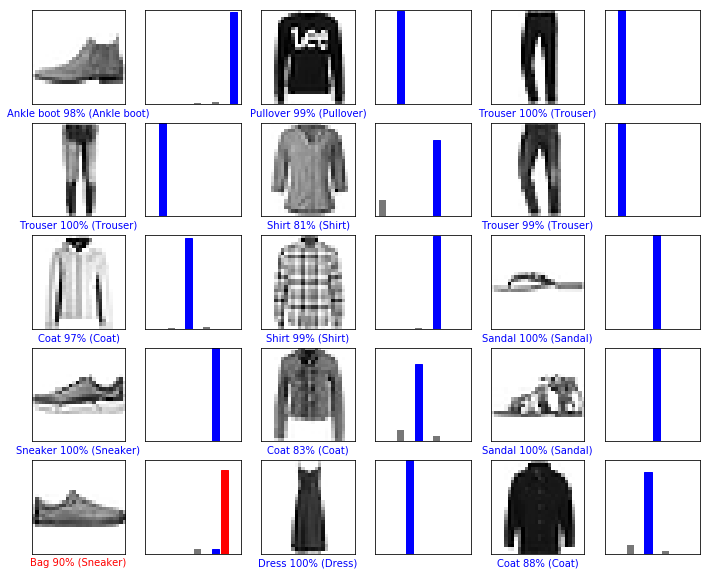

In [0]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
plt.show()

In [0]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28)


In [0]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


In [0]:
predictions_single = model.predict(img)

print(predictions_single)

[[1.2441207e-05 5.7234905e-07 3.1707611e-06 2.3744076e-06 4.4779616e-05
  4.7694482e-03 3.0884439e-06 1.8524915e-02 1.2257142e-04 9.7651666e-01]]


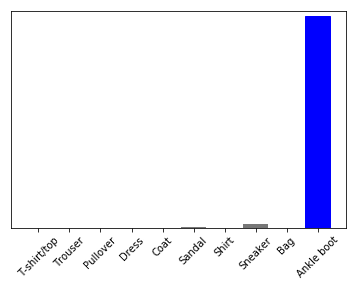

In [0]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [0]:
np.argmax(predictions_single[0])

9

In [0]:
# Кастомная модель

In [0]:
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

In [0]:
model2 = keras.Sequential([
    
    keras.layers.Conv2D(32, (5, 5), activation=tf.nn.relu, input_shape=(28, 28, 1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Conv2D(64 , kernel_size=(5,5), strides=1, padding='same',activation=tf.nn.relu),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
    
])

In [0]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        51264     
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 12, 12, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)              0         
__________

In [0]:
model2.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model2.fit(train_images, train_labels, epochs=40, batch_size = 64, validation_split = 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 5s 98us/sample - loss: 0.3985 - acc: 0.8565 - val_loss: 0.3123 - val_acc: 0.8824
Epoch 2/40
48000/48000 [==============================] - 4s 87us/sample - loss: 0.2655 - acc: 0.9028 - val_loss: 0.2913 - val_acc: 0.8938
Epoch 3/40
48000/48000 [==============================] - 4s 87us/sample - loss: 0.2240 - acc: 0.9177 - val_loss: 0.2988 - val_acc: 0.8917
Epoch 4/40
48000/48000 [==============================] - 4s 86us/sample - loss: 0.1905 - acc: 0.9299 - val_loss: 0.2855 - val_acc: 0.9000
Epoch 5/40
48000/48000 [==============================] - 4s 87us/sample - loss: 0.1681 - acc: 0.9375 - val_loss: 0.3722 - val_acc: 0.8717
Epoch 6/40
48000/48000 [==============================] - 4s 86us/sample - loss: 0.1483 - acc: 0.9441 - val_loss: 0.2772 - val_acc: 0.9082
Epoch 7/40
48000/48000 [==============================] - 4s 86us/sample - loss: 0.1269 - acc: 0.9528 - val_loss: 0.

In [0]:
test_loss, test_acc2 = model2.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc2)

10000/10000 [==============================] - 1s 65us/sample - loss: 0.6507 - acc: 0.9102
Test accuracy: 0.9102


<h3 style="text-align: center;"><b>На выбор: Style Transfer или CIFAR10 (каждое по 5 баллов)</b></h3>

В этой части Вам нужно самостоятельно реализовать перенос стиля на TensorFlow или написать классификацию датасета CIFAR10. Можно сделать и то, и то, тогда вы получите 10 баллов, а не 5, и за всё задание будет 15, а не 10.

#### Neural Style Transfer:
Бейзлайн по переносу стиля: https://github.com/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb
Это уже почти решение, надо только написать это сюда и объяснить каждый шаг, и показать пример работы на своих картинках.

In [0]:
import os
img_dir = '/tmp/nst'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg


!wget --quiet -P /tmp/nst/ https://i.pinimg.com/originals/fd/ef/73/fdef73895a8fa8f4e33691628dea0ed8.jpg
!mv /tmp/nst/fdef73895a8fa8f4e33691628dea0ed8.jpg /tmp/nst/img1.jpg
!wget --quiet -P /tmp/nst/ https://avatanplus.com/files/effects/mid/5b2a767169bfa1641ddeab19.jpg
!mv /tmp/nst/5b2a767169bfa1641ddeab19.jpg /tmp/nst/img2.jpg

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [0]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [5]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [0]:
# Set up some global values here
content_path = '/tmp/nst/img2.jpg'
style_path = '/tmp/nst/img1.jpg'

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

In [0]:
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

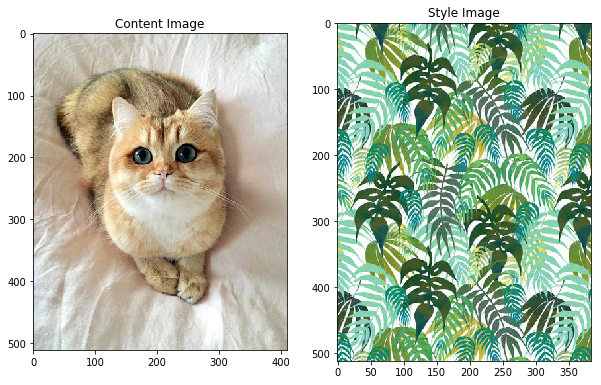

In [9]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

In [0]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [0]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [0]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
def get_model():
  """ Creates our model with access to intermediate layers. 
  
  This function will load the VGG19 model and access the intermediate layers. 
  These layers will then be used to create a new model that will take input image
  and return the outputs from these intermediate layers from the VGG model. 
  
  Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
  """
  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

In [0]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

In [0]:
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

In [0]:
def get_feature_representations(model, content_path, style_path):
  """Helper function to compute our content and style feature representations.

  This function will simply load and preprocess both the content and style 
  images from their path. Then it will feed them through the network to obtain
  the outputs of the intermediate layers. 
  
  Arguments:
    model: The model that we are using.
    content_path: The path to the content image.
    style_path: The path to the style image
    
  Returns:
    returns the style features and the content features. 
  """
  # Load our images in 
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

In [0]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  """This function will compute the loss total loss.
  
  Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
      our optimization process. We apply the gradients wrt the loss we are 
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the 
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of 
      interest.
      
  Returns:
    returns the total loss, style loss, content loss, and total variational loss
  """
  style_weight, content_weight = loss_weights
  
  # Feed our init image through our model. This will give us the content and 
  # style representations at our desired layers. Since we're using eager
  # our model is callable just like any other function!
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

In [0]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

In [0]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false. 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tfe.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

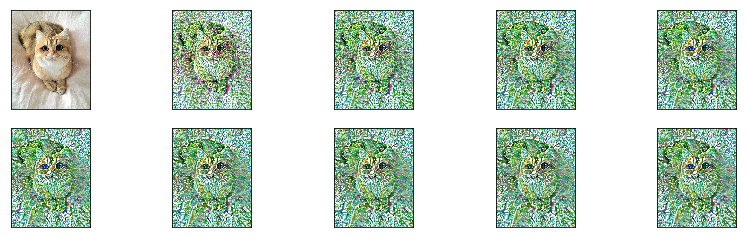

In [20]:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=1000)

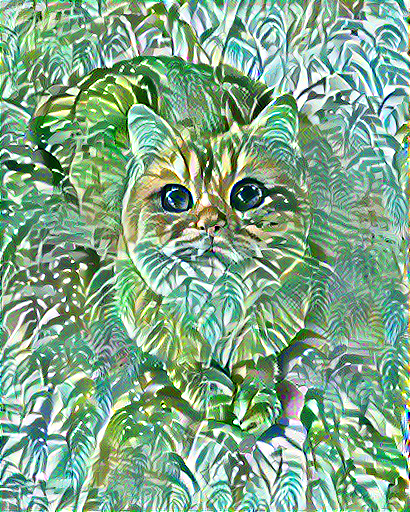

In [21]:
Image.fromarray(best)

In [0]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

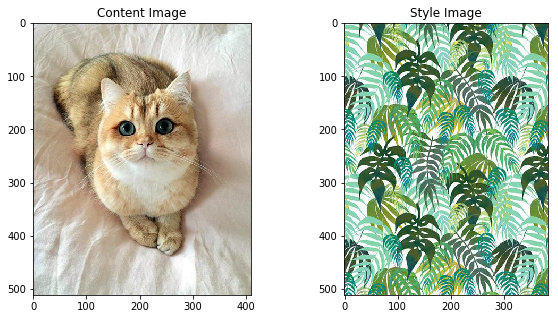

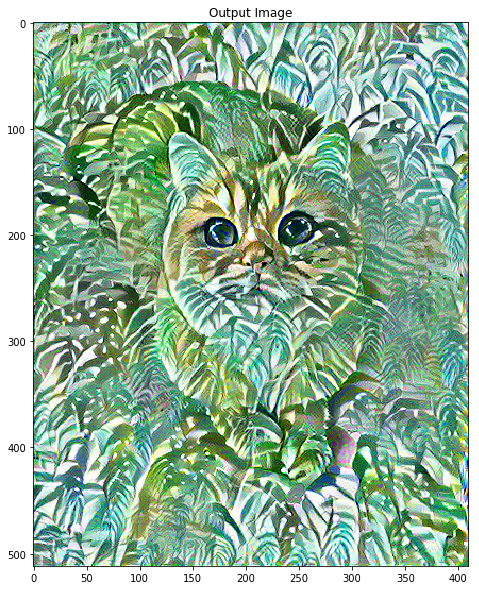

In [23]:
show_results(best, content_path, style_path)

# Котик в джунглях получился

#### CIFAR10:
Бейзлайн по классификации CIFAR10: https://www.tensorflow.org/tutorials/images/deep_cnn  
Там есть ссылки на файлы с кодом, который тоже можно прямо сюда вставлять, главное, чтобы качество в итоге получилось хорошим (формально порог не задан, будет смотреться у всех индивиуально).

In [0]:
from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.13.1


In [0]:
cifar10 = keras.datasets.cifar10

In [0]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170500096/170498071 [==============================] - 40s 0us/step


In [0]:
class_names = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [0]:
train_images.shape

(50000, 32, 32, 3)

In [0]:
test_images.shape

(10000, 32, 32, 3)

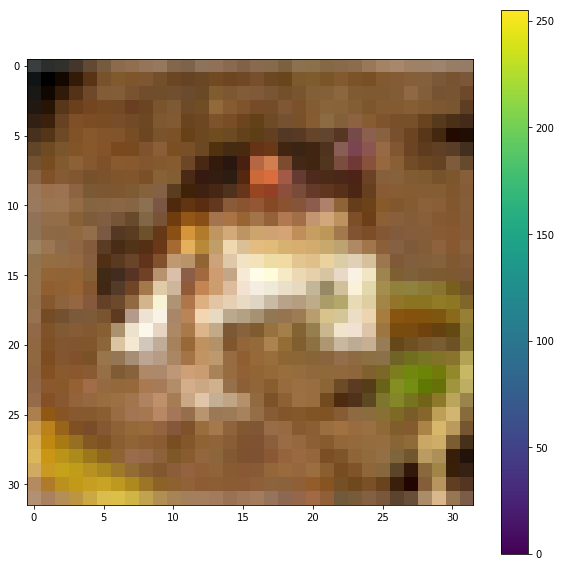

In [0]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [0]:
train_images = train_images / 255.0

test_images = test_images / 255.0

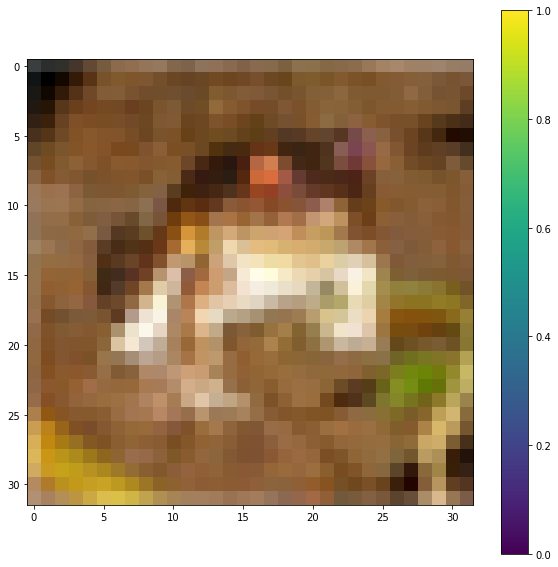

In [0]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

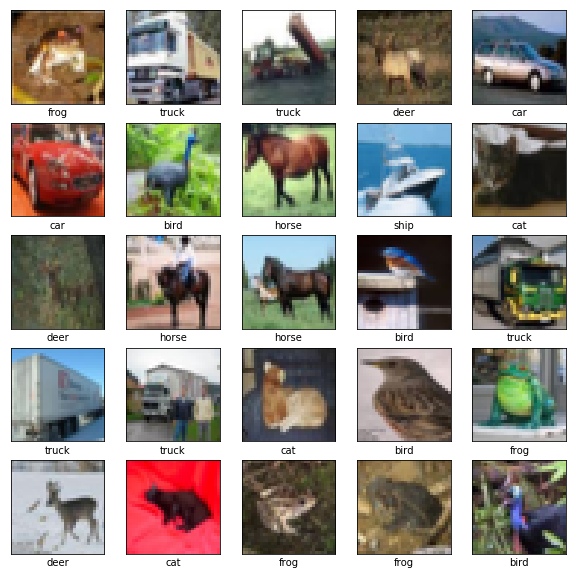

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32, 3)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [0]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
50000/50000 [==============================] - 6s 118us/sample - loss: 1.8955 - acc: 0.3207
Epoch 2/5
50000/50000 [==============================] - 5s 109us/sample - loss: 1.7362 - acc: 0.3785
Epoch 3/5
50000/50000 [==============================] - 5s 109us/sample - loss: 1.6788 - acc: 0.4000
Epoch 4/5
50000/50000 [==============================] - 5s 109us/sample - loss: 1.6439 - acc: 0.4153
Epoch 5/5
50000/50000 [==============================] - 5s 109us/sample - loss: 1.6200 - acc: 0.4241


In [0]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 1s 95us/sample - loss: 1.6256 - acc: 0.4117
Test accuracy: 0.4117


In [0]:
predictions = model.predict(test_images)

In [0]:
predictions[0]

array([0.07421969, 0.07521199, 0.08650588, 0.17397346, 0.07656538,
       0.10282899, 0.16434518, 0.00360362, 0.22983994, 0.01290594],
      dtype=float32)

In [0]:
np.argmax(predictions[0])

8

In [0]:
test_labels[0]

array([3])

In [0]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label[0]]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label[0]].set_color('blue')


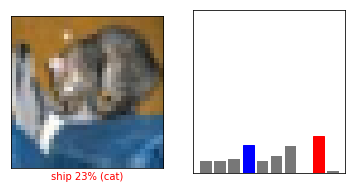

In [0]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

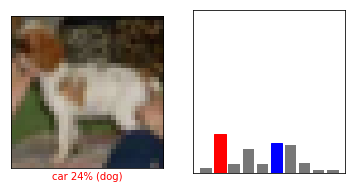

In [0]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

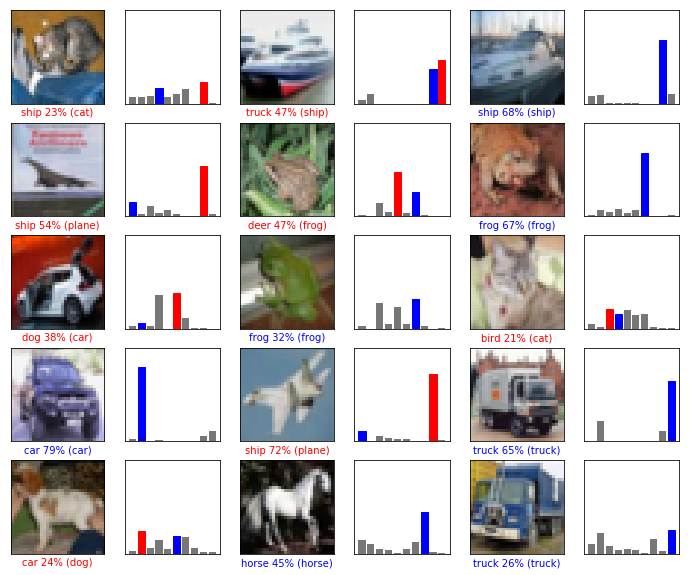

In [0]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
plt.show()

In [0]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(32, 32, 3)


In [0]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 32, 32, 3)


In [0]:
predictions_single = model.predict(img)

print(predictions_single)

[[0.07421968 0.07521198 0.08650587 0.17397344 0.07656537 0.10282898
  0.16434516 0.00360362 0.22983992 0.01290594]]


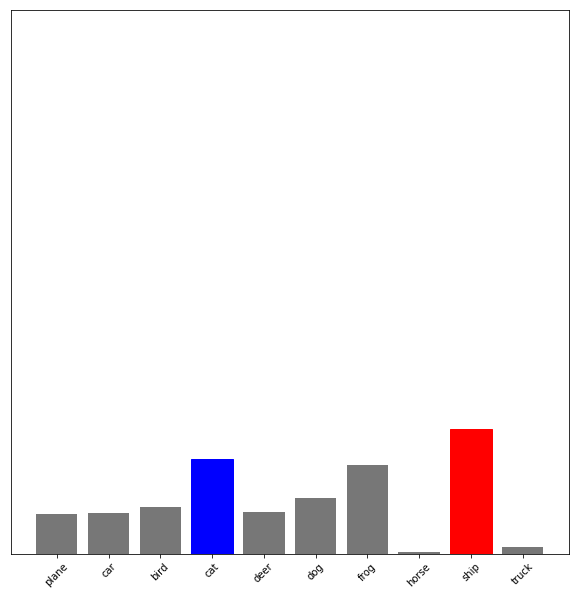

In [0]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [0]:
np.argmax(predictions_single[0])

8

In [0]:
# Кастомная модель

In [0]:
test_images.shape

(10000, 32, 32, 3)

In [0]:
train_images = train_images.reshape((50000, 32, 32, 3))
test_images = test_images.reshape((10000, 32, 32, 3))

In [0]:
model2 = keras.Sequential([
    
    keras.layers.Conv2D(32, (5, 5), activation=tf.nn.relu, input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Conv2D(64 , kernel_size=(5,5), strides=1, padding='same',activation=tf.nn.relu),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
    
])

In [0]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        2432      
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3136)              0         
__________

In [0]:
model2.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model2.fit(train_images, train_labels, epochs=100, batch_size = 64, validation_split = 0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 5s 136us/sample - loss: 1.4351 - acc: 0.4895 - val_loss: 1.3867 - val_acc: 0.5076
Epoch 2/100
40000/40000 [==============================] - 5s 128us/sample - loss: 1.0536 - acc: 0.6275 - val_loss: 1.3494 - val_acc: 0.5477
Epoch 3/100
40000/40000 [==============================] - 5s 132us/sample - loss: 0.8779 - acc: 0.6914 - val_loss: 1.3136 - val_acc: 0.5596
Epoch 4/100
40000/40000 [==============================] - 5s 122us/sample - loss: 0.7503 - acc: 0.7352 - val_loss: 2.2108 - val_acc: 0.4416
Epoch 5/100
40000/40000 [==============================] - 5s 119us/sample - loss: 0.6445 - acc: 0.7720 - val_loss: 1.0959 - val_acc: 0.6509
Epoch 6/100
40000/40000 [==============================] - 5s 122us/sample - loss: 0.5493 - acc: 0.8066 - val_loss: 0.9781 - val_acc: 0.6836
Epoch 7/100
40000/40000 [==============================] - 5s 122us/sample - loss: 0.4612 - acc: 0.8378 

In [0]:
test_loss, test_acc2 = model2.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc2)

10000/10000 [==============================] - 1s 100us/sample - loss: 3.0095 - acc: 0.6833
Test accuracy: 0.6833
